# Prize-Collecting Steiner Trees
## Imports

In [1]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import tqdm
import time

# Import custom libraries
import neighborhoods as nbh

In [2]:
# Reload modules in case of modifications
reload(nbh)

<module 'neighborhoods' from '/home/braunger/masterthesis/python_code/PCST/neighborhoods.py'>

In [3]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"

## Get prized list for DE genes

In [4]:
terminal_df = pd.read_csv(data_dir+'de_data/fc_top10.csv')
terminal_df.head()

,transition,gene,FPKM_t0,FPKM_t1,log2_fc,abs_log2_fc
0,fc_70_80,PI16,351.71975,17.206346,-4.353414,4.353414
1,fc_50_60,ACAN,2.99550,58.069632,4.276915,4.276915
2,fc_50_60,NTN4,3.42550,64.420368,4.233130,4.233130
3,fc_0_10,ACTG2,28.01490,1.564571,-4.162355,4.162355
4,fc_70_80,CLDN11,5.67700,76.747923,3.756927,3.756927


In [5]:
# get DE genes for the first transition (t0)
prizes_data_t0 = terminal_df.copy()
prizes_data_t0 = prizes_data_t0[prizes_data_t0['transition'] == "fc_0_10"]
prizes_data_t0['gene'] = prizes_data_t0['gene'] + "_t0"

# get DE genes for the second transition (t1)
prizes_data_t1 = terminal_df.copy()
prizes_data_t1 = prizes_data_t1[prizes_data_t1['transition'] == "fc_10_20"]
prizes_data_t1['gene'] = prizes_data_t1['gene'] + "_t1"

prizes_data = pd.concat([prizes_data_t0, prizes_data_t1])
prizes_data.columns = ['transition', 'name', 'FPKM_t0', 'FPKM_t1', 'log2_fc', 'prize']
prizes_data = prizes_data[['name', 'prize']]
prizes_data.head()

,name,prize
3,ACTG2_t0,4.162355
23,NTN4_t0,2.852316
34,ACAN_t0,2.716139
38,PTGDS_t0,2.643388
42,NEFM_t0,2.585507


In [6]:
# Save prizes df to tsv
prizes_data.to_csv(save_dir+'de_terminals.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

In [7]:
terminals = list(prizes_data['name'])
n_terminals = len(terminals)
print('Number of terminals: ' + str(n_terminals))

Number of terminals: 2630


## Get edge weights

In [8]:
# load duplicated STRING interactome
interactome = pd.read_csv(data_dir + 'ppi_data/PPI_string_duplicated.csv', sep = '\t')
# add pseudocount, so none of the edges has cost zero
interactome['cost'] = interactome['cost'] + 0.01
interactome.head()

,protein1,protein2,cost
0,M6PR_t0,ARF5_t0,1.001755
1,CYP51A1_t0,ARF5_t0,0.951107
2,OSBPL7_t0,ARF5_t0,0.986443
3,PPP5C_t0,ARF5_t0,0.993510
4,RALBP1_t0,ARF5_t0,0.980554


In [9]:
interactome.shape

(22250448, 3)

In [10]:
# Test with iRef
iRef = pd.read_csv(data_dir + 'ppi_data/iRefIndex_v14_MIScore_interactome_C9.costs.txt', sep = '\t')

# add t0 and t1 suffix
iRef_t0 = iRef.copy()
iRef_t0['protein1'] = iRef_t0['protein1'] + '_t0'
iRef_t0['protein2'] = iRef_t0['protein2'] + '_t0'

iRef_t1 = iRef.copy()
iRef_t1['protein1'] = iRef_t1['protein1'] + '_t1'
iRef_t1['protein2'] = iRef_t1['protein2'] + '_t1'

interactome = pd.concat([iRef_t0, iRef_t1])

interactome.head()

,protein1,protein2,cost
0,C9ORF72_t0,ACTB_t0,0.598835
1,C9ORF72_t0,ACTN4_t0,0.598835
2,C9ORF72_t0,ACTR2_t0,0.598835
3,C9ORF72_t0,ACTR3_t0,0.598835
4,C9ORF72_t0,ACTR3B_t0,0.598835


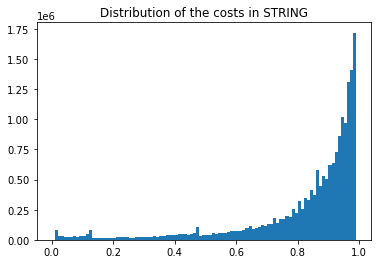

In [10]:
# cost distribution in STRING
plt.figure()
plt.hist(interactome['cost'],
         bins=np.arange(0, 1, 0.01))
plt.title('Distribution of the costs in STRING')
plt.show()

In [11]:
# load TF-target interactions
tf_targets = pd.read_csv(data_dir + 'tf_data/tftarget_full_processed.csv', sep = '\t')
tf_targets = tf_targets[['tf', 'target_gene']].drop_duplicates()
tf_targets.columns = ['protein1', 'protein2']
tf_targets['cost'] = np.median(interactome['cost'])

tf_targets.head()

,protein1,protein2,cost
0,LMNB1_t0,AGBL5-AS1_t1,0.932261
1,LMNB1_t0,AGBL5_t1,0.932261
2,LMNB1_t0,RP11-204L24.2_t1,0.932261
3,LMNB1_t0,CLASP1_t1,0.932261
4,LMNB1_t0,RNU4ATAC_t1,0.932261


In [12]:
# filter TF-target interactions to the ones included in STRING
# since hTF also includes non-protein-coding genes
tf_targets = tf_targets[tf_targets['protein1'].isin(interactome['protein1'])]
tf_targets = tf_targets[tf_targets['protein2'].isin(interactome['protein2'])]

In [13]:
n_TFs = len(tf_targets['protein1'].unique())
print('After the filtering '+ str(n_TFs)+ ' TFs out of 48 are left.')

After the filtering 43 TFs out of 48 are left.


In [14]:
# combine STRING with TF-targets and save results
full_PPI = pd.concat([interactome, tf_targets])
full_PPI.to_csv(data_dir + 'ppi_data/PPI_string_TFs.csv', sep='\t')

In [58]:
min(full_PPI['cost'])

0.01

In [59]:
tf_targets.shape

(195003, 3)

In [60]:
tf_targets.iloc[0:5,:]

,protein1,protein2,cost
1,LMNB1_t0,AGBL5_t1,0.932261
3,LMNB1_t0,CLASP1_t1,0.932261
21,LMNB1_t0,PER1_t1,0.932261
24,LMNB1_t0,MTRNR2L1_t1,0.932261
30,LMNB1_t0,FLOT1_t1,0.932261


In [30]:
set(tf_targets['protein2'].tolist())

{'CIAO1_t1',
 'ADAM19_t1',
 'BAP1_t1',
 'PDE6G_t1',
 'KANK2_t1',
 'SLC15A2_t1',
 'MTFMT_t1',
 'NLGN1_t1',
 'GPATCH1_t1',
 'OR14A2_t1',
 'WDR46_t1',
 'SCAP_t1',
 'CTXN1_t1',
 'CYP4A22_t1',
 'ONECUT2_t1',
 'PRPF4_t1',
 'ZNF781_t1',
 'RPL19_t1',
 'SHOX_t1',
 'EPHX4_t1',
 'RYR2_t1',
 'RAI14_t1',
 'SNX2_t1',
 'PLD5_t1',
 'CEP41_t1',
 'GJA9_t1',
 'MYCN_t1',
 'GLB1L2_t1',
 'ARMCX4_t1',
 'COL9A1_t1',
 'ADPRH_t1',
 'ARL13A_t1',
 'P2RY10_t1',
 'CCL5_t1',
 'DNAH11_t1',
 'LHX1_t1',
 'SMCP_t1',
 'IQGAP3_t1',
 'TOLLIP_t1',
 'SLC22A6_t1',
 'TOMM40L_t1',
 'PRELID1_t1',
 'DBN1_t1',
 'RNF115_t1',
 'TMEM229A_t1',
 'RPN2_t1',
 'ZBTB8A_t1',
 'CLPTM1L_t1',
 'ZBED8_t1',
 'PCDHA12_t1',
 'NUB1_t1',
 'BUB3_t1',
 'SEMG1_t1',
 'MED17_t1',
 'CCL26_t1',
 'PPP1R32_t1',
 'THOC7_t1',
 'PSORS1C2_t1',
 'PUS7_t1',
 'YOD1_t1',
 'URI1_t1',
 'SORBS1_t1',
 'SELE_t1',
 'SNAP23_t1',
 'TMEM14C_t1',
 'MGMT_t1',
 'MYL12A_t1',
 'OR8D4_t1',
 'C9orf78_t1',
 'AHCYL1_t1',
 'JTB_t1',
 'TCERG1_t1',
 'USP2_t1',
 'SLC36A3_t1',
 'SNTN_t1',

## Run PCST

In [21]:
# STRING interactome with TF-targets interactions
interactome_file_name = data_dir + 'ppi_data/PPI_string_TFs.csv'
# Prize file
prize_file_name = save_dir+'de_terminals.tsv'

In [22]:
# Graph hyperparameters
graph_params =  {
                "w": 2,
                "b": 5,
                "g": 0,
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }

In [23]:
# Build graph
graph = oi.Graph(interactome_file_name, graph_params)

In [24]:
graph.prepare_prizes(prize_file_name)

08:37:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:37:34 - OI2: INFO - []
08:37:34 - OI2: INFO - Members of the prize file not present in the interactome:
08:37:34 - OI2: INFO - ['ABLIM1_t1', 'ACTA2_t0', 'ACTB_t0', 'ALX3_t0', 'ALX4_t0', 'ALX4_t1', 'ATP8B1_t0', 'ATP8B1_t1', 'BMP2K_t1', 'C14orf132_t1', 'C1R_t1', 'CAPS_t0', 'CARD16_t0', 'CARD16_t1', 'CHAC1_t0', 'CHAC1_t1', 'CYFIP2_t0', 'CYFIP2_t1', 'DPF3_t0', 'EEF1AKMT4_t1', 'EFNB2_t1', 'ELN_t0', 'ELN_t1', 'ENPP1_t0', 'ENPP1_t1', 'FBXL15_t1', 'FOXC1_t0', 'FOXC2_t0', 'FOXC2_t1', 'FOXL2_t0', 'FOXP1_t0', 'GCLC_t0', 'GJC1_t0', 'GSTT1_t0', 'GSTT1_t1', 'HOXA13_t0', 'HYI_t0', 'IGF1R_t0', 'INAFM2_t0', 'INPP5F_t0', 'ITM2B_t0', 'KLHL13_t0', 'LHB_t0', 'LHB_t1', 'LMBRD1_t1', 'LPP_t0', 'LYNX1_t0', 'MAP3K6_t1', 'MYO1F_t1', 'NLGN4Y_t1', 'NNAT_t0', 'NT5C3A_t0', 'ORAI1_t0', 'PITX2_t1', 'POTEF_t0', 'PTPRQ_t0', 'RPS4Y1_t1', 'S100A13_t0', 'S100A13_t1', 'SERAC1_t0', 'SH3BP1_t0', 'SLC35E2A_t0', 'SLC52A2_t1', 'SPEGNB

In [25]:
# Run PCSF
vertex_indices, edge_indices = graph.pcsf()
forest, augmented_forest = graph.output_forest_as_networkx(vertex_indices, edge_indices)

## Analysis of the results

In [40]:
# Number of nodes and edges
n_nodes = augmented_forest.number_of_nodes()
n_edges = augmented_forest.number_of_edges()
print('The Steiner tree has ' + str(n_nodes) + ' nodes and ' + str(n_edges) + ' edges.')

The Steiner tree has 5084 nodes and 519017 edges.


In [41]:
number_components = len([c for c in nx.connected_components(augmented_forest)])
size_components = [len(c) for c in sorted(nx.connected_components(augmented_forest), key=len, reverse=True)]

network_df = oi.get_networkx_graph_as_dataframe_of_nodes(augmented_forest)
percentage_terminals = np.sum(network_df['terminal'])/n_terminals
percentage_terminals

#nx.get_edge_attributes(augmented_forest,'cost')

0.9730038022813688

In [42]:
network_df[network_df.index == 'LMNB1_t0']

,prize,terminal,type,degree,betweenness,louvain_clusters
LMNB1_t0,0.0,False,protein,3532,0.500313,1


In [43]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(augmented_forest, filename=save_dir + "test_network.html")
oi.output_networkx_graph_as_pickle(augmented_forest, filename= save_dir + "test_network.pickle")

PosixPath('/home/braunger/masterthesis/save/pcst/test_network.pickle')

## Neighborhood analysis

In [44]:
# Add edge confidence to attributes
nbh.add_edge_confidence(augmented_forest)

# Color map bounds for nodes
min_prize = np.floor(min(nx.get_node_attributes(augmented_forest,'log2_fc').values()))
max_prize = np.floor(max(nx.get_node_attributes(augmented_forest,'log2_fc').values()))+1
vmin_nodes = -max(abs(min_prize),abs(max_prize))
vmax_nodes = max(abs(min_prize),abs(max_prize))

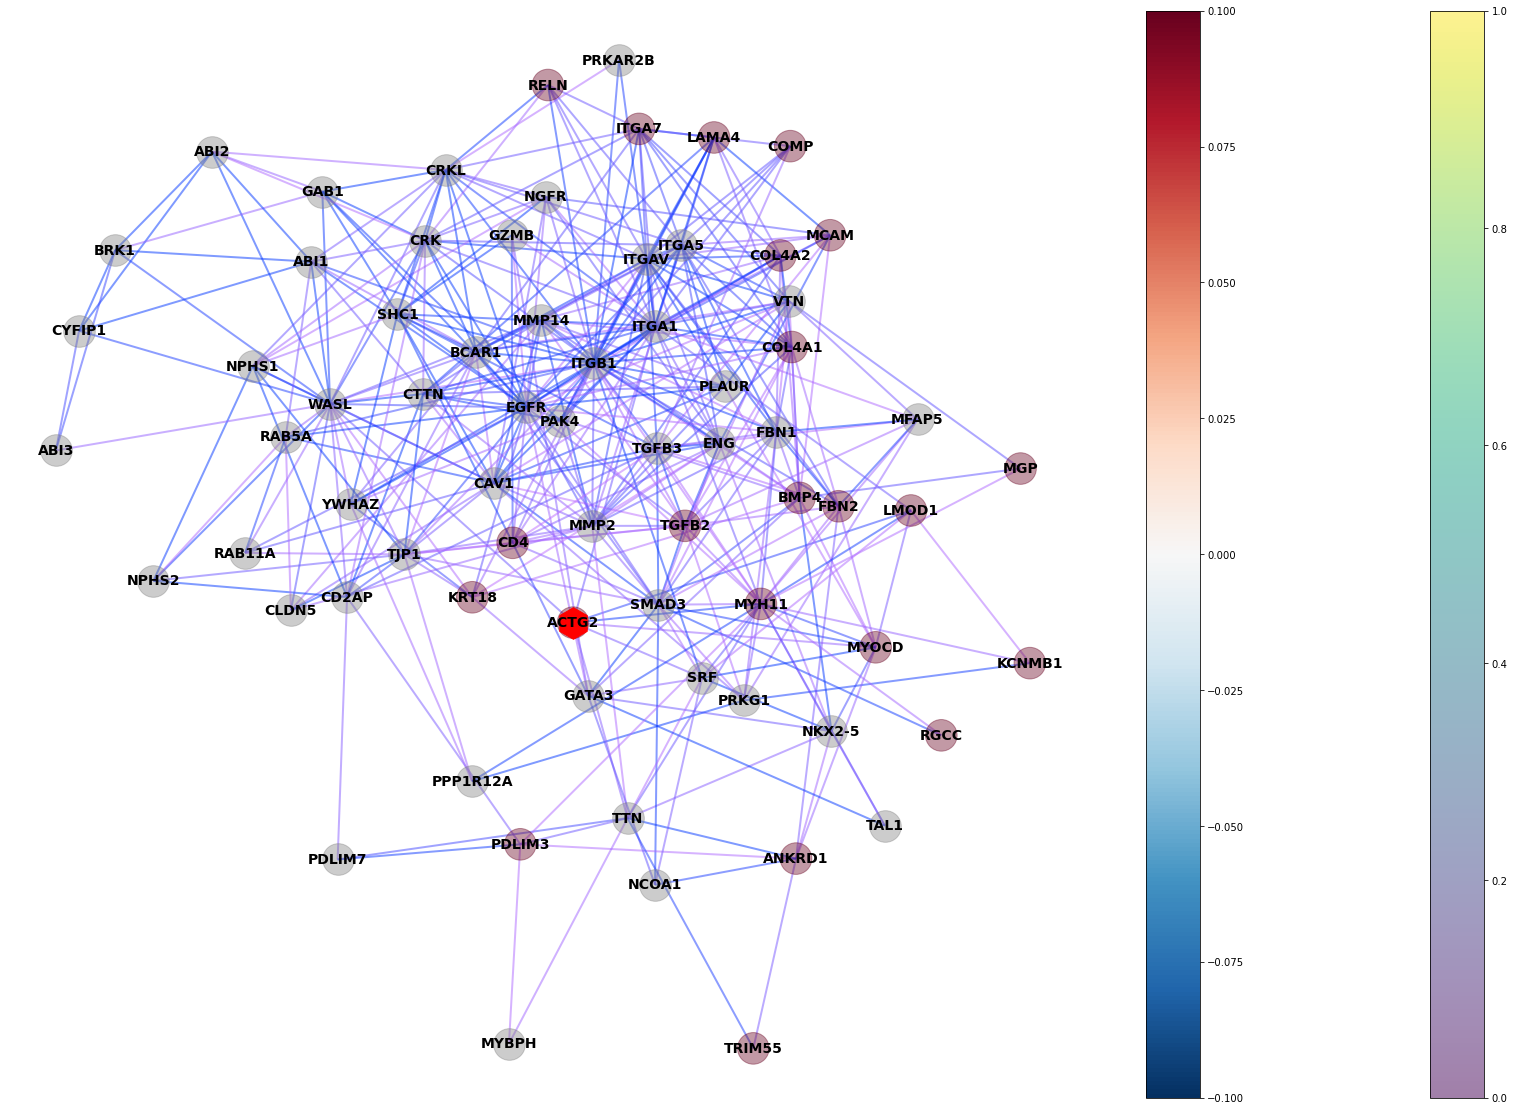

In [55]:
# Plot neighborhood of protein_center
protein_center = 'ACTG2'

nbh.plot_neighborhood_subnetwork(protein_center,
                                 augmented_forest,
                                 vmin_nodes,
                                 vmax_nodes,
                                 vmin_edges = 0,
                                 vmax_edges = 1,
                                 removeUBC = False, 
                                 cthreshold = 0.6, 
                                 nodesize = 1000,
                                 save=False)